In [2]:
#valid high-order interaction: can pass the assumed statistical inspection
#see the distribtion in different bin resolution
#divide into several order group

# generated control region

In [196]:
%%writefile "/public/home/lizw/task/pore_c/nc_new_result/local_high_order/contact_count.py"
from pathlib import Path,PurePath
import pyarrow
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import zwTools

def porec_merge(mpq:int,porec_dir:str,prefix:str):
    align_dir = Path(PurePath(porec_dir,'align_table'))
    align_dir_porec_generator \
    = align_dir \
    .glob(prefix + "*pore_c.parquet")
    
    align_batch_porec_merge_df \
    = pyarrow \
    .concat_tables(list(map(pq.read_table,align_dir_porec_generator))) \
    .to_pandas()
    
    align_batch_porec_merge_df_pass \
    = align_batch_porec_merge_df \
    .query('pass_filter==True') \
    .query('mapping_quality>=@mpq')
    
    align_batch_porec_merge_df_pass = align_batch_porec_merge_df_pass.assign(
        pos = lambda x: np.rint((x.fragment_start + x.fragment_end)*0.5)
        .astype(int)
        )
    return align_batch_porec_merge_df_pass

porec_rep1 = porec_merge(mpq=1
                         ,porec_dir="/public/home/lizw/task/pore_c/porec_1000_filter_mainchr_result"
                         ,prefix='DpnII_run2-1'
                        )

porec_rep1_sub = porec_rep1.reindex(['chrom','fragment_start','fragment_end','pos','read_name'],axis = 1)
genome = pd.read_table('/public/home/lizw/data/IMPORTANT_genome/arabidopsis/col-CEN/dna/faCount.result',header=None,names=['chr','size'])

region = genome.copy()
region['region_end'] = genome['size']
region['region_start'] = 0
region['region_index'] = region.index
region.rename(columns={'chr':'region_chr'},inplace = True)
region.rename(columns={'size':'region_size'},inplace = True)

region = region[['region_chr','region_start','region_end','region_size','region_index']]
a,b,c,d = zwTools.chr_interval(porec_rep1_sub,region,'pos',1000000)
porec_rep1_sub_interval = b

porec_rep1_sub_drop_du = porec_rep1_sub_interval.drop_duplicates(subset=['chrom','pos','read_name'])

porec_rep1_sub_drop_du['contact'] = porec_rep1_sub_drop_du.groupby(by=['chrom','interval','read_name']).transform('count')['fragment_start']

porec_rep1_sub_drop_du_high_contact = porec_rep1_sub_drop_du.query('contact>=2')

porec_rep1_high_contact_group = porec_rep1_sub_drop_du_high_contact.groupby(by=['chrom','interval','read_name'])

dir_parent = Path('/public/home/lizw/task/pore_c/porec_1000_filter_mainchr_result/nc_new_result/local_high_order/control')

def write_bed(x,chrom):
    index = x.name
    filename = Path(f'{index}.bed')
    bed_ser = pd.DataFrame(x.T)
    bed_df = pd.DataFrame(bed_ser.iloc[:,0].tolist(),index=bed_ser.index)
    bed_df.insert(0,'chr',chrom)
    bed_df.to_csv(dir_sub/filename,index=None,sep="\t",header=False)

dir_n = 0
for group_idx,read_sample in porec_rep1_high_contact_group:
    read_sample.sort_values(by='fragment_start',inplace = True)
    read_sample['fragment_control_base'] = read_sample['fragment_start'].min()
    read_sample.eval('fragment_control_dis=fragment_start-fragment_control_base',inplace=True)
    chrom = read_sample.iloc[0,0]
    geno_end = genome.query('chr==@chrom').iloc[0,1]
    random_end = geno_end - read_sample['fragment_control_dis'].max()
    start_list = np.random.choice(random_end,size=100)

    control_dict_start = dict()
    control_dict_end = dict()
    control_dict = dict()
    dir_parent = Path('/public/home/lizw/task/pore_c/nc_new_result/local_high_order/control')
    dir_sub = dir_parent / Path(str(dir_n))
    dir_sub.mkdir(exist_ok=True)
    for i in read_sample.itertuples():
        index,chrom,fragment_start,fragment_end,*other,control_dis = i
        fragment_length = fragment_end - fragment_start
        control_dict_start[index] = start_list + control_dis
        control_dict_end[index] = start_list + control_dis + fragment_length
        control_dict[index] = [(control_dict_start[index][i],control_dict_end[index][i]) for i in np.arange(100)]

    control_df = pd.DataFrame(control_dict)
    control_df.apply(write_bed,axis=1,args=(chrom,))
    dir_n+=1

Overwriting /public/home/lizw/task/pore_c/nc_new_result/local_high_order/contact_count.py


<module 'zwTools' from '/public/home/lizw/anaconda3/envs/normal/lib/python3.8/site-packages/zwTools.py'>

# NEW plan

In [1]:
#@Author: Zhuowen Li
#@LastEdit: 2022/1/4 下午5:36:16
#@Version: v3
#@Description: remove bin max normalization and use the Ratio

In [2]:
%config InlineBackend.figure_format = 'retina'

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.font_manager as font_manager
import matplotlib as mpl
import matplotlib.patches as mp
import seaborn as sns

## functions

In [40]:
#@Author: Zhuowen Li
#@LastEdit: 2021/12/22 下午1:05:34
#@Version: v2
#@Description:  the control when calculating the accumulation of porec reads might not be necessary... and the bin normalization(or scaled) can be take into consideration
from pathlib import Path,PurePath
import pyarrow
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import zwTools

def porec_merge(mpq:int,porec_dir:str,prefix:str):
    align_dir = Path(PurePath(porec_dir,'align_table'))
    align_dir_porec_generator \
    = align_dir \
    .glob(prefix + "*pore_c.parquet")
    
    align_batch_porec_merge_df \
    = pyarrow \
    .concat_tables(list(map(pq.read_table,align_dir_porec_generator))) \
    .to_pandas()
    
    align_batch_porec_merge_df_pass \
    = align_batch_porec_merge_df \
    .query('pass_filter==True') \
    .query('mapping_quality>=@mpq')
    
    align_batch_porec_merge_df_pass = align_batch_porec_merge_df_pass.assign(
        pos = lambda x: np.rint((x.fragment_start + x.fragment_end)*0.5)
        .astype(int)
        )
    return align_batch_porec_merge_df_pass

def contact_nor_multigroup_df(porec_df,region,resolution):
    porecsub = porec_df.reindex(['chrom','fragment_start','fragment_end','pos','read_name'],axis = 1)
    a,b,c,d = zwTools.chr_interval(porecsub,region,'pos',resolution)
    porecsub_interval = b
    porecsub_drop_du = porecsub_interval.drop_duplicates(subset=['chrom','pos','read_name'])
    porecsub_drop_du['chr_interval'] = [(rows['chrom'],rows['interval'].left,rows['interval'].right) for i,rows in porecsub_drop_du.iterrows()]
    porecsub_drop_du['contact'] = porecsub_drop_du.groupby(
        by=['chrom','interval','read_name']
    ).transform('count')['fragment_start']
    return porecsub_drop_du

def contact_nor_series(porecsub_drop_du,contact_filter):
    porecsub_drop_du_high_contact = porecsub_drop_du.query(contact_filter)
    porecmulti_cal = porecsub_drop_du_high_contact.groupby(by=['chrom','chr_interval']).count()['contact'].reindex(('Chr1','Chr2','Chr3','Chr4','Chr5'),axis=0,level=0).reset_index()
    #normalized with all
    porecall_cal = porecsub_drop_du.groupby(by=['chrom','chr_interval']).count()['contact'].reindex(('Chr1','Chr2','Chr3','Chr4','Chr5'),axis=0,level=0).reset_index()
    porec_high_merge = pd.merge(porecall_cal,porecmulti_cal,on=['chrom','chr_interval'])
    porec_high_merge.loc[porec_high_merge['contact_x'] < 5,'contact_x'] = 0
    porec_high_merge_nor = porec_high_merge.assign(
        contact_nor = lambda x:x['contact_y']/x['contact_x']
    ).dropna()
#     porec_high_merge_nor_ser = porec_high_merge_nor['contact_nor']
#     porec_interval = porec_high_merge_nor.reindex(['chrom','chr_interval'],axis=1)
    
    return porec_high_merge_nor

def contact_nor_series_by_single(porecsub_drop_du,contact_filter):
    porecsub_drop_du_high_contact = porecsub_drop_du.query(contact_filter)
    porecsub_drop_du_single = porecsub_drop_du.query('contact == 1')
    porecmulti_cal = porecsub_drop_du_high_contact.groupby(by=['chrom','chr_interval']).count()['contact'].reindex(('Chr1','Chr2','Chr3','Chr4','Chr5'),axis=0,level=0).reset_index()
    #normalized with all
    porecsingle_cal = porecsub_drop_du_single.groupby(by=['chrom','chr_interval']).count()['contact'].reindex(('Chr1','Chr2','Chr3','Chr4','Chr5'),axis=0,level=0).reset_index()
    porec_high_merge = pd.merge(porecsingle_cal,porecmulti_cal,on=['chrom','chr_interval'])
    porec_high_merge.loc[porec_high_merge['contact_x'] < 5,'contact_x'] = 0
    porec_high_merge_nor = porec_high_merge.assign(
        contact_nor = lambda x:(x['contact_y']/x['contact_x'])/(x['contact_y']/x['contact_x']).max()
    ).dropna()
#     porec_high_merge_nor_ser = porec_high_merge_nor['contact_nor']
#     porec_interval = porec_high_merge_nor.reindex(['chrom','chr_interval'],axis=1)
    
    return porec_high_merge_nor



def multi_contact_merge(porecsub_drop_du,contact_filter_list,norkind):
    n = 0
    for contact_filter in contact_filter_list:
        if norkind == 'all':
            porec_high_merge_nor = contact_nor_series(porecsub_drop_du,contact_filter)
        elif norkind == 'singleton':
            porec_high_merge_nor = contact_nor_series_by_single(porecsub_drop_du,contact_filter)
        porec_high_merge_nor_reindex =  porec_high_merge_nor.reindex(['chrom','chr_interval','contact_nor'],axis=1)
        porec_high_merge_nor_reindex.fillna(0,inplace=True)
        if n == 0:
            porec_high_merge_nor_multigroup = porec_high_merge_nor_reindex
        porec_high_merge_nor_reindex.rename({'contact_nor':contact_filter},axis=1,inplace=True)
        if n > 0:
            porec_high_merge_nor_multigroup = pd.merge(porec_high_merge_nor_multigroup,porec_high_merge_nor_reindex,on=['chrom','chr_interval'],how='outer',sort=True)
        n += 1
    porec_high_merge_nor_multigroup.fillna(0,inplace=True)
    return porec_high_merge_nor_multigroup

## draw box

In [23]:
def rec_part(region_iter,df,kind,ax,binsize,yflen,**other):
    region_chr,region_start,region_end,region_size,region_index,region_cum = region_iter
    df['chrom'] = df['chrom'].apply(lambda x:str(x))
    df_sub = df.query('(chrom == @region_chr) and (end >= @region_start) and (start <= @region_end)')
    df_sub = df[df['chrom']==region_chr]
    for k in df_sub.itertuples(index=False):
        if kind == 'mark':
            df_chr,df_start,df_end,df_name,df_color = k
            bottom = 0.20/yflen
            ec_color = 'black'
        if kind == 'anchor':
            df_chr,df_start,df_end,df_name = k
            df_color = '#C00000'
            bottom = 0.40/yflen
            ec_color = '#C00000'
        
        left = df_start
        width = df_end - df_start + 1
        ax.add_patch(plt.Rectangle((left,bottom),width,0.075/yflen,color=df_color,ec = ec_color))
        remove_draw(ax,tick=False,spine = False,locator = False)
        ax.spines.top.set_visible(False)
        for axis in ['left','bottom','right']:
            ax.spines[axis].set_alpha(0.7)
            ax.spines[axis].set_color('#bdbebd')
        
        ax.set_xlabel(f'chr{region_chr}')
        ax.patch.set_alpha(0)
        ax.set_yticks([])
        ax.set_xlim(left=region_start,right=region_end)
        x_ticks = np.arange(region_start,region_end,10*binsize)
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(x_ticks,rotation=45,ha='right')
            
def rec_draw(region_df_cum,mainplot,anchor,binsize,gs,yflen,anchormode,**other):
    last_cum = 0
    for region_iter in region_df_cum.itertuples(index=False):
        region_cum = region_iter[-1]
        ax_rec = mainplot.add_subplot(gs[0,last_cum:region_cum])
        if other is not None:
            if 'gene' in other:
                gene_model_draw(ax_rec,other['gene'],region_iter,yflen)
            if 'mark' in other:
                rec_part(region_iter,other['mark'],'mark',ax_rec,binsize,yflen)
        rec_part(region_iter,anchor,'anchor',ax_rec,binsize,yflen)
        last_cum = region_cum

# read porec_df

In [24]:
porec_m = porec_merge(mpq=1
                         ,porec_dir="/public/home/lizw/task/pore_c/porec_1000_filter_mainchr_result"
                         ,prefix='DpnII_run2-m'
                        )

## whole genome

In [83]:
genome = pd.read_table('/public/home/lizw/data/IMPORTANT_genome/arabidopsis/col-CEN/dna/faCount.result',header=None,names=['chr','size'])
resolution = 1000_000
region = genome.copy()
region['region_end'] = genome['size']
region['region_start'] = 0
region['region_index'] = region.index
region.rename(columns={'chr':'region_chr'},inplace = True)
region.rename(columns={'size':'region_size'},inplace = True)
region = region[['region_chr','region_start','region_end','region_size','region_index']]

In [84]:
porecsub_drop_du = contact_nor_multigroup_df(porec_m,region,resolution)
contact_filter_list = ['contact==1',
                       'contact==2',
                       '(contact>=3) and (contact <= 5)', 
                       'contact>5'
                      ]
porec_high_merge_nor_multigroup_byall = multi_contact_merge(porecsub_drop_du,contact_filter_list,'all')

In [85]:
porec_high_merge_nor_multigroup_byall_no1 = porec_high_merge_nor_multigroup_byall.drop(columns=['contact==1'])

In [86]:
def contact_draw(multigroup_df,region,prefix):
    font_dirs = ['/public/home/mowp/test/fonts/']
    font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

    for font_file in font_files:
        font_manager.fontManager.addfont(font_file)

    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['font.size'] = 30
    plt.rcParams['svg.fonttype'] = 'none'
    fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(50,5), sharey=True)
    n = 0 
    for i in ['Chr1', 'Chr2', 'Chr3', 'Chr4', 'Chr5']:
        ax_chr = ax[n]
        df = multigroup_df.query('chrom == @i')
        df.reset_index(inplace=True,drop=True)
        re_size = len(df)

        df.plot(ax=ax_chr,lw=2,legend=False)
        #ax_chr.plot(df,lw=2)
        re_df = region.query('region_chr == @i')

        #round the label to M unit
        re_start_round = np.round(re_df.iloc[0,1] / 1000_000,decimals=1)
        re_end_round = np.round(re_df.iloc[0,2] / 1000_000,decimals=1)

        ax_chr.set_xticks([0, re_size])
        ax_chr.set_xticklabels([f'{re_start_round}', f'{re_end_round}M'])

        ax_chr.title.set_text(i)
        sns.despine(ax=ax_chr)
        n += 1

    from matplotlib.lines import Line2D
    color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']
    custom_lines = [Line2D([0], [0], color=color_list[0], lw=2),
                    Line2D([0], [0], color=color_list[1], lw=2),
                    Line2D([0], [0], color=color_list[2], lw=2)]


    ax[5].legend(custom_lines, ['2','3-5','>5'],loc='upper left')
    ax[5].spines['right'].set_color('none')
    ax[5].spines['bottom'].set_color('none')
    ax[5].spines['left'].set_color('none')
    ax[5].spines['top'].set_color('none')
    ax[5].set_xticks([])
    ax[5].set_yticks([])

    
    plt.ylim(0, 0.4)
    plt.yticks([0,0.4])
    ax[0].set_ylabel('Local Count Ratio')
    plt.savefig(f'/public/home/lizw/task/pore_c/nc_new_result/contact_plot/{prefix}_high_order_contact_distribution.png',format='png',dpi=300,bbox_inches='tight')

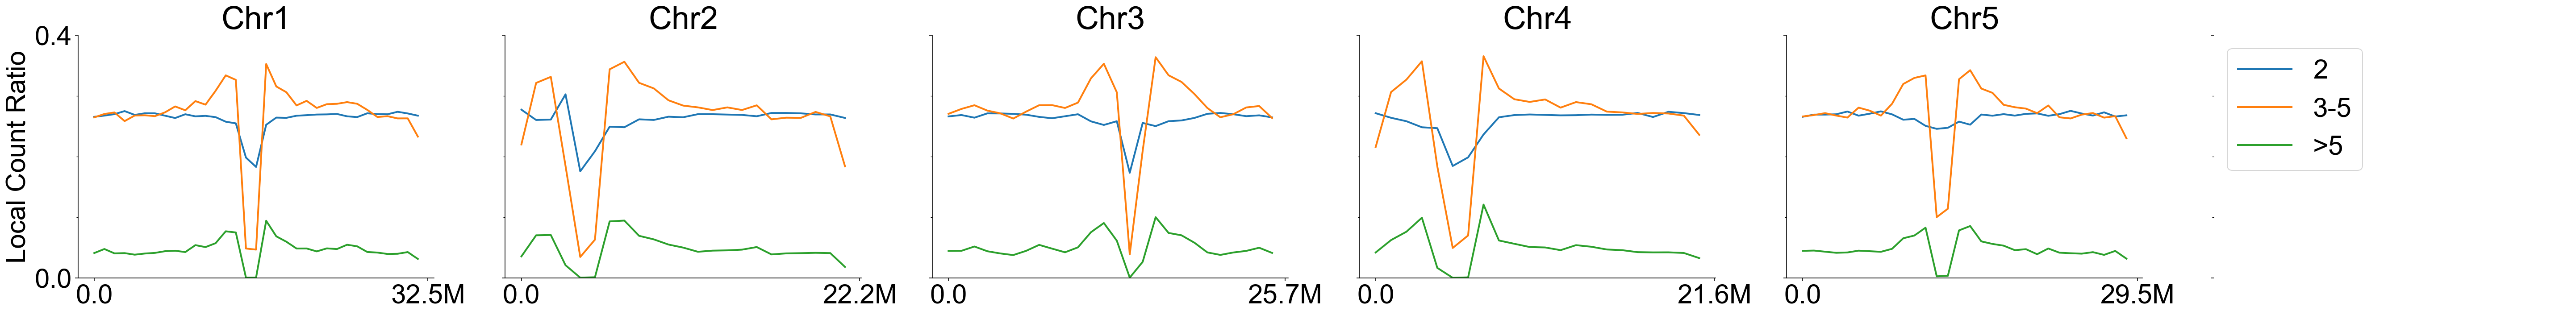

In [87]:
contact_draw(porec_high_merge_nor_multigroup_byall_no1,region,'whole_genome_byall')

## cens

In [29]:
cen = pd.read_table('/public/home/lizw/task/pore_c/nc_new_result/porecplot/plot/cen.bed',header=None,usecols=[0,1,2],names=['region_chr','region_start','region_end'])

In [30]:
cen['region_size'] = cen['region_end'] - cen['region_start']

In [31]:
cen['region_index'] = cen.index

In [32]:
cen_500k = cen.copy()

In [33]:
extend_region = 500_000

In [34]:
cen_500k['region_start'] = cen_500k['region_start']-extend_region
cen_500k['region_end'] = cen_500k['region_end']+extend_region
cen_500k['region_size'] = cen_500k['region_end'] -cen_500k['region_start']

In [35]:
cen_500k

,region_chr,region_start,region_end,region_size,region_index
0,Chr1,14341109,18059778,3718669,0
1,Chr2,3323791,6545243,3221452,1
2,Chr3,13097187,16233925,3136738,2
3,Chr4,3703901,7477949,3774048,3
4,Chr5,11284130,15051809,3767679,4


In [36]:
CEN_porecsub_drop_du = contact_nor_multigroup_df(porec_m,cen_500k,100_000)
contact_filter_list = ['contact==1',
                       'contact==2',
                       '(contact>=3) and (contact <= 5)', 
                       'contact>5'
                      ]
CEN_porec_high_merge_nor_multigroup = multi_contact_merge(CEN_porecsub_drop_du,contact_filter_list)

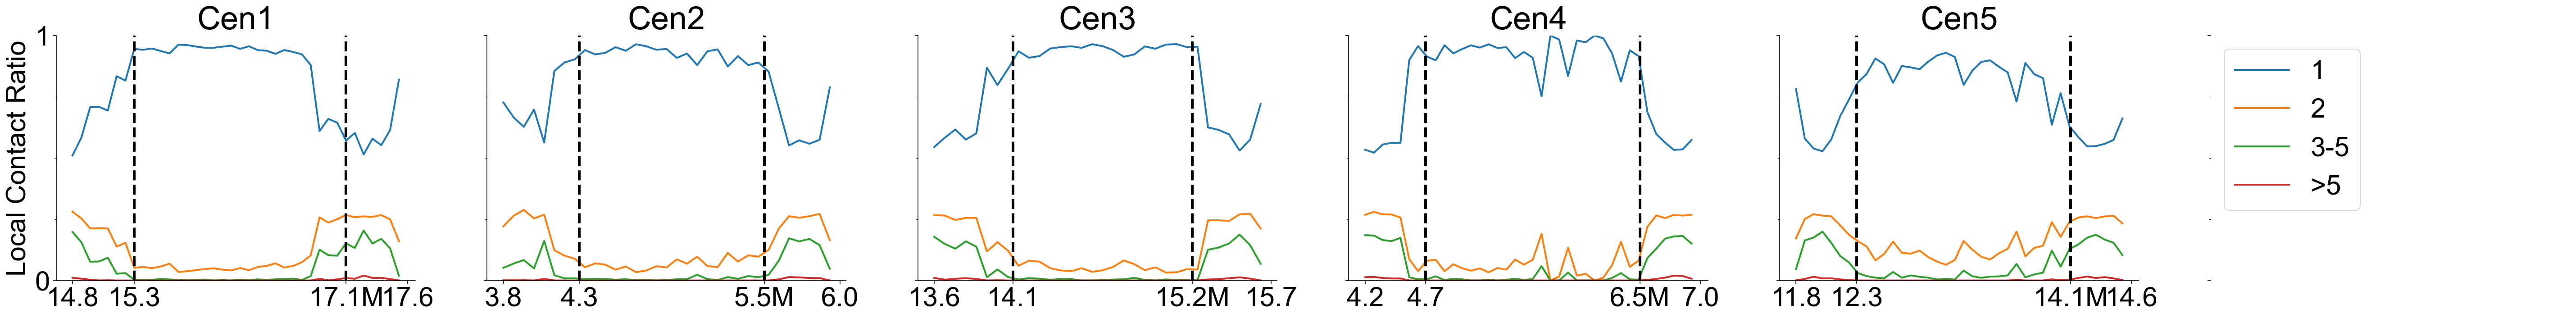

In [37]:
font_dirs = ['/public/home/mowp/test/fonts/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 30
plt.rcParams['svg.fonttype'] = 'none'
fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(50,5), sharey=True)
n = 0 
for i in ['Chr1', 'Chr2', 'Chr3', 'Chr4', 'Chr5']:
    ax_chr = ax[n]
    df = CEN_porec_high_merge_nor_multigroup.query('chrom == @i')
    df.reset_index(inplace=True,drop=True)
    df.plot(ax=ax_chr,lw=2,legend=False)
    #ax_chr.plot(df,lw=2)
    re_df = cen.query('region_chr == @i')
    re_size = len(df)
    re_size_ori = re_df.iloc[0,3]
    extend_draw = extend_region/re_size_ori * re_size
    ax_chr.plot([extend_draw,extend_draw],[0,1],'k--',lw=3,)
    ax_chr.plot([re_size-extend_draw,re_size-extend_draw],[0,1],'k--',lw=3,)
    #round the label to M unit
    re_start_round = np.round(re_df.iloc[0,1] / 1000_000,decimals=1)
    re_end_round = np.round(re_df.iloc[0,2] / 1000_000,decimals=1)
    
    re_start_inner = np.round((re_df.iloc[0,1]+extend_region)/ 1000_000,decimals=1)
    re_end_inner = np.round((re_df.iloc[0,2]-extend_region) / 1000_000,decimals=1)
    
    ax_chr.set_xticks([0, re_size,extend_draw, re_size-extend_draw])
    ax_chr.set_xticklabels([f'{re_start_round}', f'{re_end_round}',f'{re_start_inner}', f'{re_end_inner}M'])

#     ax_chr.set_xticks([extend_draw,re_size-extend_draw])
#     ax_chr.set_xticklabels([f'{re_start_inner}', f'{re_end_inner}M'])
    
    ax_chr.title.set_text(f'Cen{i[-1]}')
    sns.despine(ax=ax_chr)
    n += 1

from matplotlib.lines import Line2D
color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']
custom_lines = [Line2D([0], [0], color=color_list[0], lw=2),
                Line2D([0], [0], color=color_list[1], lw=2),
                Line2D([0], [0], color=color_list[2], lw=2),
                Line2D([0], [0], color=color_list[3], lw=2)]


ax[5].legend(custom_lines, ['1','2','3-5','>5'],loc='upper left')
ax[5].spines['right'].set_color('none')
ax[5].spines['bottom'].set_color('none')
ax[5].spines['left'].set_color('none')
ax[5].spines['top'].set_color('none')
ax[5].set_xticks([])
ax[5].set_yticks([])


plt.ylim(0, 1)
plt.yticks([0, 1])
ax[0].set_ylabel('Local Contact Ratio')
plt.savefig('/public/home/lizw/task/pore_c/nc_new_result/contact_plot/Cen_high_order_contact_distribution.png',format='png',dpi=300,bbox_inches='tight')

# violin plot

In [38]:
CEN_ONLY_porecsub_drop_du = contact_nor_multigroup_df(porec_m,cen,100_000)
contact_filter_list = ['contact>=2']
CEN_ONLY_porec_high_merge_nor_multigroup = multi_contact_merge(CEN_ONLY_porecsub_drop_du,contact_filter_list)

<AxesSubplot:xlabel='chrom', ylabel='contact>=2'>

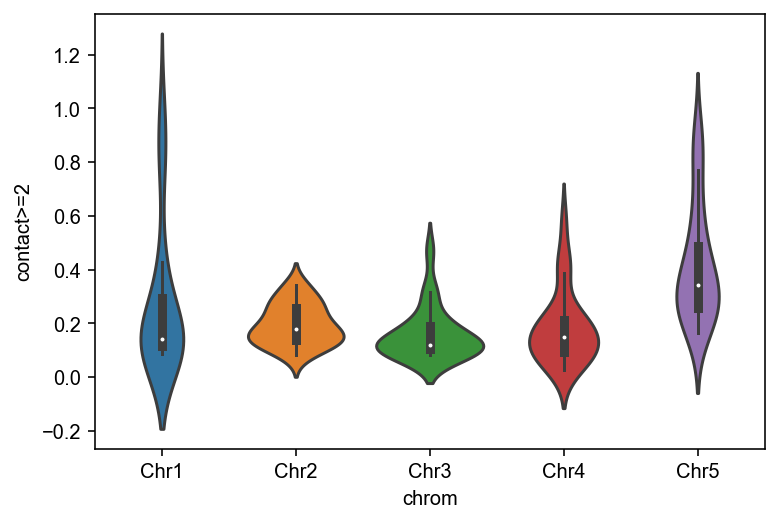

In [21]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10
plt.rcParams['svg.fonttype'] = 'none'
sns.violinplot(data =CEN_ONLY_porec_high_merge_nor_multigroup, x='chrom',y='contact>=2')
sns.lineplot()